In [1]:
import os

root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'data/data')

train_path = os.path.join(data_dir, 'X_train.csv')
test_path = os.path.join(data_dir, 'X_test.csv')

### Feature extraction

* FFT
* Wavelet
* Statistical features (tsfel)

In [2]:
import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import welch
from scipy.fftpack import fft
from scipy import signal


/home/coder/tmp/ipykernel_71907/1930109289.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
X_train = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)
X_train.head(1)

,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,...,value_200,value_201,value_202,value_203,value_204,value_205,value_206,value_207,value_208,value_209
0,0.298922,0.433164,0.282143,0.500285,0.500285,0.600968,0.70165,0.567406,0.600968,0.600968,...,-0.909258,-0.744475,-0.540092,-0.573652,-0.808577,-0.238382,-0.875698,-0.851534,-0.842137,-1.0435


In [4]:
N = 210     # длина сигнала
f_s = 1    # frequency multiplied by 3600 (1 hour)
t_n = N  # lenth of signal in hours
T = t_n / N # период сигнала
sample_rate = 1 / f_s
denominator = 10

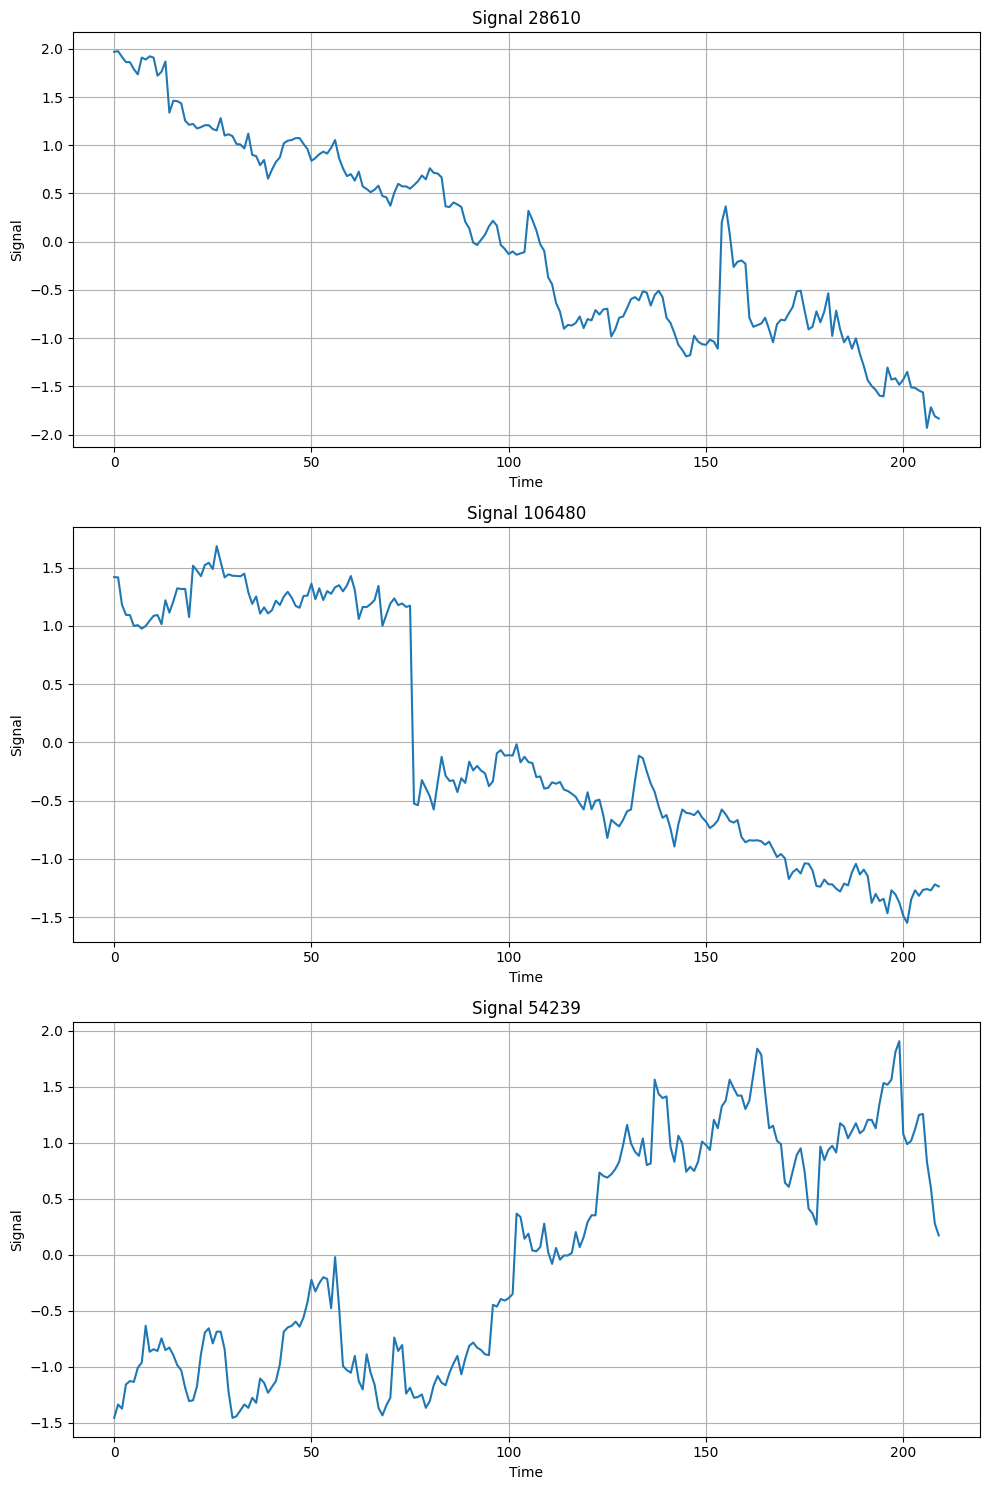

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# draw 3 random signals at different axes
for i in range(3):
    rnd_idx = np.random.randint(0, len(X_train))
    signal = X_train.iloc[rnd_idx].values
    ax[i].plot(signal)
    ax[i].set_title(f'Signal {rnd_idx}')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Signal')
    ax[i].grid(True)

plt.tight_layout()

### FFT

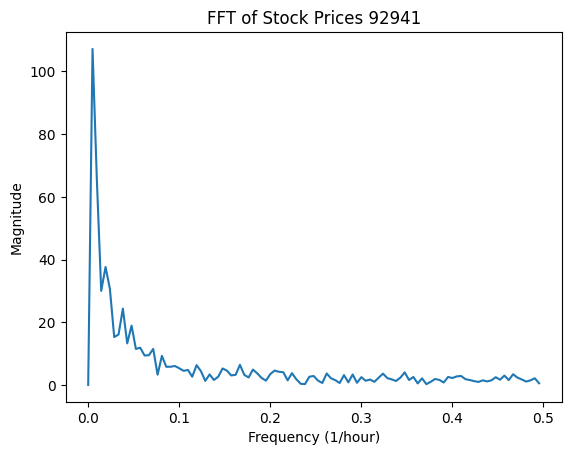

In [6]:
# Assuming 'prices' is the 210-point time series data
rnd_idx = np.random.randint(0, len(X_train))
prices = X_train.iloc[rnd_idx].values

# Perform FFT
fft_values = np.fft.fft(prices)

# Compute the corresponding frequencies
N = len(prices)  # Number of data points
T = 1.0  # Time interval between samples (1 hour)
frequencies = np.fft.fftfreq(N, T)

# Plot the FFT result (magnitude vs. frequency)
plt.plot(frequencies[:N//2], np.abs(fft_values[:N//2]))
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Magnitude')
plt.title('FFT of Stock Prices ' + str(rnd_idx))
plt.show()


Hmm, it looks like it always has some sort of peak with very low frequency. \
I think, it indicates that the stock price has a long-term trend, but we want to predict the short-term trend (the next day's price). \
It means that it doesn't make much sense to use fft features for this problem.

### Wavelet

Wavelet transform is a good tool for analyzing non-stationary time series data. \
After some discussion with GPT and browsing the internet, I decided to use db6, db12, db18 for Daubechies, 'sym' for Symlets transforms. \
I'll use some code from the seminar notebook. Also, I'll add some more features to it.

In [7]:
from collections import Counter
import scipy.stats

def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    energy = np.nanmean(list_values**2)
    skew = scipy.stats.skew(list_values)
    kurtosis = scipy.stats.kurtosis(list_values)
    return [n5, n25, n75, n95, median, mean, std, var, rms, energy, skew, kurtosis]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(
        np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_datates(dataset, waveletnames):
    all_features = []
    waveletnames = [waveletnames] if type(waveletnames) == str else waveletnames
    for signal_no in tqdm(range(0, len(dataset)), leave=False):
        signal = dataset[signal_no, :]
        
        list_coeff = []
        for name in waveletnames:
            list_coeff += pywt.wavedec(signal, name)
        
        features = []
        for coeff in list_coeff:
            features += get_features(coeff)
        
        all_features.append(features)
    return np.array(all_features)

Text(0.5, 1.0, 'Wavelet of Stock Prices 40304')

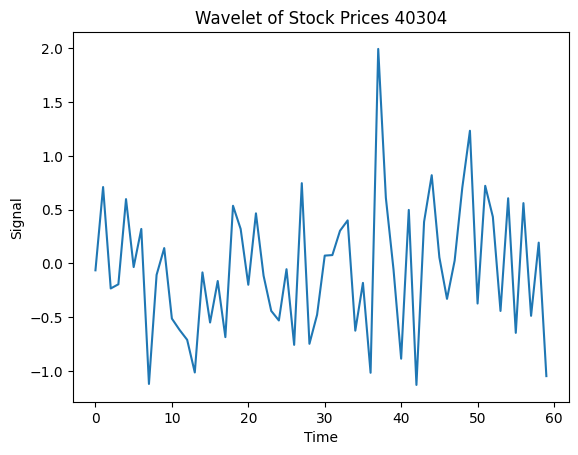

In [8]:
import pywt

# Assuming 'prices' is the 210-point time series data
rnd_idx = np.random.randint(0, len(X_train))
prices = X_train.iloc[rnd_idx].values

waveletname = 'db6'
plt.plot(pywt.wavedec(prices, waveletname)[-2])
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Wavelet of Stock Prices ' + str(rnd_idx))

In [9]:
wt_list = ['db12', 'db18', 'sym12', 'sym18']
X_train_wavelet = get_datates(X_train.values, wt_list)
X_test_wavelet = get_datates(X_test.values, wt_list)

  0%|          | 0/108298 [00:00<?, ?it/s]

In [10]:
X_train_wavelet.shape, X_test_wavelet.shape

((108298, 210), (19112, 210))

In [11]:
np.save(os.path.join(data_dir, 'X_train_wavelet.npy'), X_train_wavelet)
np.save(os.path.join(data_dir, 'X_test_wavelet.npy'), X_test_wavelet)

### Tsfel features

Here I'll just take some features from the tsfel library. \
I'll use temporal features. Also, I will remove features that are highly correlated with each other or have a zero variance (basically constants).

In [19]:
import tsfel

# Get individual feature configurations
temporal_cfg = tsfel.get_features_by_domain('temporal')
statistical_cfg = tsfel.get_features_by_domain('statistical')
spectral_cfg = tsfel.get_features_by_domain('spectral')

# Merge the configurations
cfg_files = [temporal_cfg, statistical_cfg]

def extract_tsfel_features(data):
    fs = 1
    features = []
    for cfg_file in cfg_files:
        features.append(tsfel.time_series_features_extractor(cfg_file, data.values[:,:,None], fs=fs))
        print(f'Extracted {features[-1].shape} features')
    return np.concatenate(features, axis=1)

In [21]:
fs = 1  # Sampling frequency (1 sample per hour)
X_train_features = extract_tsfel_features(X_train)
X_test_features = extract_tsfel_features(X_test)

Extracted (108298, 14) features


/home/coder/.local/lib/rolos-python/site-packages/tsfel/feature_extraction/features.py:498: FutureWarning: The histogram feature was deprecated in version 0.1.8 and will be replaced by the mode of histogram in 0.1.9. From then on, only a single feature value will be returned.
  warnings.warn(
/home/coder/.local/lib/rolos-python/site-packages/tsfel/feature_extraction/features.py:498: FutureWarning: The histogram feature was deprecated in version 0.1.8 and will be replaced by the mode of histogram in 0.1.9. From then on, only a single feature value will be returned.
  warnings.warn(
/home/coder/.local/lib/rolos-python/site-packages/tsfel/feature_extraction/features.py:498: FutureWarning: The histogram feature was deprecated in version 0.1.8 and will be replaced by the mode of histogram in 0.1.9. From then on, only a single feature value will be returned.
  warnings.warn(
/home/coder/.local/lib/rolos-python/site-packages/tsfel/feature_extraction/features.py:498: FutureWarning: The histogr

Extracted (108298, 40) features


Extracted (19112, 14) features


/home/coder/.local/lib/rolos-python/site-packages/tsfel/feature_extraction/features.py:498: FutureWarning: The histogram feature was deprecated in version 0.1.8 and will be replaced by the mode of histogram in 0.1.9. From then on, only a single feature value will be returned.
  warnings.warn(
/home/coder/.local/lib/rolos-python/site-packages/tsfel/feature_extraction/features.py:498: FutureWarning: The histogram feature was deprecated in version 0.1.8 and will be replaced by the mode of histogram in 0.1.9. From then on, only a single feature value will be returned.
  warnings.warn(
/home/coder/.local/lib/rolos-python/site-packages/tsfel/feature_extraction/features.py:498: FutureWarning: The histogram feature was deprecated in version 0.1.8 and will be replaced by the mode of histogram in 0.1.9. From then on, only a single feature value will be returned.
  warnings.warn(
/home/coder/.local/lib/rolos-python/site-packages/tsfel/feature_extraction/features.py:498: FutureWarning: The histogr

Extracted (19112, 40) features


In [22]:
# Good compression!
X_train_features.shape, X_train.shape

((108298, 54), (108298, 210))

In [27]:
X_train_features = pd.DataFrame(X_train_features)
X_test_features = pd.DataFrame(X_test_features)

In [28]:
corr_features = tsfel.correlated_features(X_train_features)
n_features_before_drop = X_train_features.shape[1]
X_train_features.drop(corr_features, axis=1, inplace=True)
X_test_features.drop(corr_features, axis=1, inplace=True)
print(f'Dropped {n_features_before_drop - X_train_features.shape[1]} features. {X_train_features.shape[1]} features remaining.')

Dropped 5 features. 49 features remaining.


In [29]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()
X_train_features = selector.fit_transform(X_train_features)
X_test_features = selector.transform(X_test_features)
print(f'After removing features with zero variance, {X_train_features.shape[1]} features remain.')

After removing features with zero variance, 39 features remain.


In [32]:
np.save(os.path.join(data_dir, 'X_train_tsfel_features.npy'), X_train_features)
np.save(os.path.join(data_dir, 'X_test_tsfel_features.npy'), X_test_features)

#### Time Series Scaling

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# scale along with axis=1
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

c:\Users\rodio\Desktop\Programming\ML\market_forecasting\.venv\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
random_row = np.random.randint(0, len(X_train))
n_checks = 25
for i in range(n_checks):
    random_row = np.random.randint(0, len(X_train))
    assert np.isclose(X_train_scaled[random_row].mean(), 0, atol=1e-5), 'Mean of the time series is not close to 0!'

    random_row = np.random.randint(0, len(X_test_scaled))
    assert np.isclose(X_test_scaled[random_row].mean(), 0, atol=1e-5), 'Mean of the time series is not close to 0!'

In [ ]:
np.save(os.path.join(data_dir, 'X_train_scaled.npy'), X_train_scaled)
np.save(os.path.join(data_dir, 'X_test_scaled.npy'), X_test_scaled)